In [1]:
from collections import Counter
import numpy as np
import keras
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential,Model
from keras.layers import concatenate,Activation,Dropout,Dense,ZeroPadding2D
from keras.layers import Input,add,Conv2D, MaxPooling2D,Flatten,BatchNormalization,LSTM
import os
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
from pandas import *
import json
import os
from keras.utils import to_categorical
import argparse
import time
import random
import numpy_indexed as npi
from numpy.random import default_rng
from matplotlib import pyplot as plt

from scipy import signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests  # pip install requests
%matplotlib inline

2023-06-02 16:52:30.706687: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 16:52:32.788372: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Code to turn the ECG data into image data 

In [3]:
# Make images, source and destination file

def make_plot_images(ecgs, dest):

    for ecg in ecgs:
        fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(50,4))
        sns.lineplot(ecg[0], ax=axes[0], linewidth = 0.5).set(ylim=[-2,2])
        sns.lineplot(ecg[1], ax=axes[1], color='orange', linewidth = 0.5).set(ylim=[-2,2])
        plt.tight_layout()
        plt.savefig(dest, dpi=300) #DEST SHOULD BE LOCAL1


        """ batchsize = 400
        images = []

        i = 0
        for ecg in ecgs:
            # from frequency values of -2 to 2. 4-decimal point vals in between. So thats like going from -2000 to 2000.
            batch = np.zeros((batchsize, 2, 5000, 4000)) # 4000 pixels per time
            
            i += batchsize"""

In [5]:
def make_spectro_images(ecgs, dest):
    for ecg in ecgs[:10]:
        print(ecg.shape)
        # flatten the ecg
        ecg = ecg.flatten()
        print(ecg.shape)
        
        fig, ax = plt.subplots() 
        ax.set_ylim(0,0.5)
        f, t, Sxx = signal.spectrogram(ecg)
        pc = ax.pcolormesh(t, f, Sxx, norm=mpl.colors.LogNorm(vmin=10e-10, vmax=100), cmap='gray')
        plt.show()
        plt.savefig(dest, dpi=300)
        



        """fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(50,4))
        sns.lineplot(ecg[0], ax=axes[0], linewidth = 0.5).set(ylim=[-2,2])
        sns.lineplot(ecg[1], ax=axes[1], color='orange', linewidth = 0.5).set(ylim=[-2,2])
        plt.tight_layout()
        plt.savefig(dest, dpi=300) #DEST SHOULD BE LOCAL1"""
    

Retrieved files:  0
(2, 5000)
(10000,)


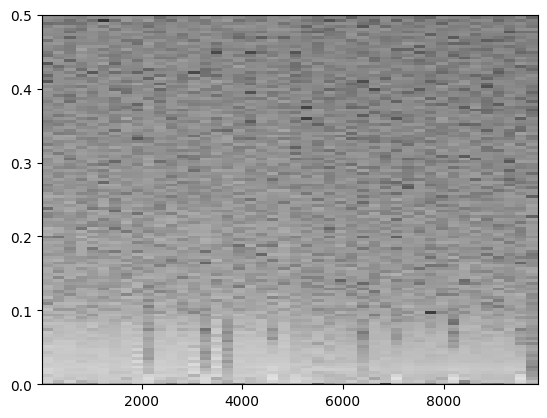

<Figure size 640x480 with 0 Axes>

In [6]:
size = 1 # do 300,000

def get_ecgs(ecg_filenames):
    X = np.zeros((size, 2, 5000))
    counter = 0
    for file in ecg_filenames:
        if counter %1000 == 0:
            print("Retrieved files: ", counter)
        patient_X = np.empty((2, 5000))

        try:
            jsonFile = open(afib_path + file, 'r')
        except:
            jsonFile = open(control_path + file, 'r')

        fileContents = json.load(jsonFile)

        # digging into the dictionaries to get lead data
        lead_1_samples = fileContents['samples']
        lead_2_samples = fileContents['extraLeads'][0]['samples']

        # Crop the data to 5000 data points.
        patient_X[0,:] = lead_1_samples[0:5000]
        patient_X[1,:] = lead_2_samples[0:5000]

        X[counter] = patient_X
        counter += 1
        jsonFile.close()
    return X

afib_path =  '../../../../../../../local1/CSE_XAI/study60_recordings_json/'
control_path = '../../../../../../../local1/CSE_XAI/control_small/'

refs = pd.read_csv("../Copy of study60_patient_recordings.csv")
sr_episodes = refs[refs["determination"]=="Sinus Rhythm"]["recording_public_id"]

afib_recordings = random.sample(list(sr_episodes), size)
afib_recordings = np.array(list(map(lambda s: s+"_raw.json", afib_recordings)))
afib_ecgs =  np.asarray(os.listdir(afib_path))
afib_ecgs = afib_ecgs[npi.indices(afib_ecgs, afib_recordings)]
afib_ecgs = get_ecgs(afib_ecgs)


make_spectro_images(afib_ecgs, "afib_spec")